In [1]:
import os
import math
import copy
import glob
import matplotlib
import multiprocessing

import numpy as np
import pandas as pd
import scipy.integrate as integrate
import PersistenceImages.persistence_images as pimg

from ripser import Rips
from matplotlib import cm
from scipy.io import loadmat
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Load Simulation Data
- Cell Type 1 (40%) - Red (plotted in dark orange)
- Cell Type 2 (60%) - Green (plotted in blue)

In [2]:
def get_sim_data(timefile, simulationtype):
    
    posfilestring = simulationtype + "/" + "Pos_" + str(timefile).zfill(7) +".dat"
    posdata = np.loadtxt(posfilestring, str, "#", ",")
    posx = []
    posy = []
    
    for val in posdata:
        
        splitpos = val.split("+")
        xpos = ""
        ypos = ""
        
        if(len(splitpos) == 2):
            xpos = splitpos[0]
            ypos = splitpos[1]
        else:
            minusindex = val[1:].find("-") + 1
            xpos = val[0:minusindex]
            ypos = val[minusindex:]
            
        ypos = ypos[:-1]
        
        if('e' in xpos):
            xpos = 0
            if('-' in ypos):
                ypos = ypos.split("-")[1]
        if('e' in ypos):
            ypos = 0
            
        xpos = [float(xpos)]
        ypos = [float(ypos)]
        posx = np.append(posx, xpos)
        posy = np.append(posy, ypos) 
        
    positions = np.column_stack((posx, posy))
    typefilestring = simulationtype + "/" + "Types_" + str(timefile).zfill(7) + ".dat"
    typedata = np.loadtxt(typefilestring, int, "#", ",")
    
    return (positions, typedata)

def visualize_sim_data(posdata):
    
    greenxpos, greenypos, redxpos, redypos = posdata
    
    plt.figure(figsize=(3,3), dpi=200)
    
    plt.scatter(greenxpos, greenypos, s=3, color='blue')
    plt.scatter(redxpos, redypos, s=3, color='darkorange')
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
    plt.show()

### Compute Order Parameters

- Cell position $\mathbf{x}_i=(x_i, y_i)$ expressed in polar coordinates $(r_i,\theta_i)$
- Total number of cells $N = N_B + N_O$
- Blue cells have type $\tau_B = 1$
- Orange cells have type $\tau_O = 2$
- For cell $i$, type is denoted by $\tau(i)$
- Adhesion between cells $i$ and $j$ is given by: $\gamma_{ij} = \gamma(\tau(i), \tau(j))$

**Angular distribution OPs:**
- Set: $d\theta = \frac{\pi}{36}$
- $\Theta(\theta) = \frac{1}{N^2}\sum_{i=1}^N\sum_{j=1,j\ne i}^N \mathbf{1}_{\theta-d\theta \le \theta_j - \theta_i \le \theta + d\theta}$ 
- $\Theta_B(\theta) = \frac{1}{N^2}\sum_{i=1}^N\sum_{j=1,j\ne i}^N \mathbf{1}_{\theta-d\theta \le \theta_j - \theta_i \le \theta + d\theta} \cdot \mathbf{1}_{\tau(j)=\tau_B}$ 
- $\Theta_O(\theta) = \frac{1}{N^2}\sum_{i=1}^N\sum_{j=1,j\ne i}^N \mathbf{1}_{\theta-d\theta \le \theta_j - \theta_i \le \theta + d\theta} \cdot \mathbf{1}_{\tau(j)=\tau_O}$
- $\displaystyle \lim_{d\theta \rightarrow 0} \int \Theta(\theta) d\theta = 1$
- $\displaystyle \lim_{d\theta \rightarrow 0} \int \Theta_B(\theta) d\theta = \frac{N_B}{N}$
- $\displaystyle \lim_{d\theta \rightarrow 0} \int \Theta_O(\theta) d\theta = \frac{N_O}{N}$

**Homotypic radial distribution OPs:**
- $R(r) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} $
- $R_B(r) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} \cdot \mathbf{1}_{\tau(j)=\tau_B}$
- $R_O(r) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} \cdot \mathbf{1}_{\tau(j)=\tau_O}$
- $\displaystyle \lim_{r \rightarrow \infty} R(r) = 1$
- $\displaystyle \lim_{r \rightarrow \infty} R_B(r) = \frac{N_B}{N}$
- $\displaystyle \lim_{r \rightarrow \infty} R_O(r) = \frac{N_O}{N}$

**Heterotypic radial distribution OPs:**
- $\widetilde{R}(r) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} \cdot \mathbf{1}_{\tau(i)\ne\tau(j)}$
- $\widetilde{R}_B(r) = \frac{1}{N \cdot N_B} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} \cdot \mathbf{1}_{\tau(i)=\tau_B\land\tau(j)=\tau_O}$
- $\widetilde{R}_O(r) = \frac{1}{N \cdot N_O} \sum_{i=1}^N \sum_{j=1,j \ne i}^N \mathbf{1}_{||\mathbf{x}_j-\mathbf{x}_i||\le r} \cdot \mathbf{1}_{\tau(i)=\tau_O\land\tau(j)=\tau_B}$
- $\displaystyle \lim_{r \rightarrow \infty} \widetilde{R}(r) = \frac{2 \cdot N_B \cdot N_O}{N^2} \Big[ = \frac{1}{N} (\text{Harmonic Mean}) \Big]$
- $\displaystyle \lim_{r \rightarrow \infty} \widetilde{R}_B(r) = \frac{N_O}{N}$
- $\displaystyle \lim_{r \rightarrow \infty} \widetilde{R}_O(r) = \frac{N_B}{N}$

In [3]:
def changetopolar(positiondata):
    
    m,n = positiondata.shape
    datcopy = np.zeros(positiondata.shape)
    
    for i in range(m):
        
        currentpoint = positiondata[i,:]
        radius = math.sqrt((currentpoint[0])*(currentpoint[0]) + (currentpoint[1])*(currentpoint[1]))
        angle = math.atan2(currentpoint[1], currentpoint[0])
        datcopy[i,0] = radius
        
        if(angle < 0):
            angle = angle + math.tau
        
        datcopy[i,1] = angle
        
    return datcopy

def dist(cell1, cell2):
    
    distan = (cell1[0]-cell2[0])*(cell1[0]-cell2[0]) + (cell1[1]-cell2[1])*(cell1[1]-cell2[1])
    distan = math.sqrt(distan)
    
    return distan

def ensemble_avg_count(positiondata, typedata):
    
    n,m = positiondata.shape
    
    r = np.linspace(0, 20, 100)
    
    avggreen = np.zeros(r.shape)
    avgred = np.zeros(r.shape)
    avgboth = np.zeros(r.shape)
    
    avggammagreen = np.zeros(r.shape)
    avggammared = np.zeros(r.shape)
    avggammaboth = np.zeros(r.shape)
    
    num_reds = np.sum(typedata == 1)
    num_greens = np.sum(typedata == 2)
    num_cells = num_greens + num_reds
    
    assert(n == num_cells)
    
    for i in range(0, n):
        
        currentcell = positiondata[i,:]
        currentcelltype = typedata[i]
        
        for j in range(r.shape[0]):
            
            radiidistance = np.apply_along_axis(dist, 1, positiondata, currentcell)
            closetypes = typedata[np.where(radiidistance <= r[j])]
            
            for m in closetypes:
                
                if (m == 2):
                    avggreen[j] += 1
                else:
                    avgred[j] +=1
                
                if (m != currentcelltype):
                    
                    if (currentcelltype == 2):
                        avggammagreen[j] += 1
                        
                    if (currentcelltype == 1):
                        avggammared[j] += 1
                        
                    avggammaboth[j] += 1
                
            avgboth[j] += closetypes.shape[0]

    avgred = np.divide(avgred, num_cells*num_cells)
    avggreen = np.divide(avggreen, num_cells*num_cells)
    avgboth = np.divide(avgboth, num_cells*num_cells)
    
    avggammared = np.divide(avggammared, num_reds*num_cells)
    avggammagreen = np.divide(avggammagreen, num_greens*num_cells)
    avggammaboth = np.divide(avggammaboth, num_cells*num_cells)
    
    return (r, avgred, avggreen, avgboth, avggammared, avggammagreen, avggammaboth)

def within(cell, theta, delta_theta):
    
    return ((cell[1] >= theta - delta_theta/2) and (cell[1] < theta + delta_theta/2))

def angularcount(positiondata, typedata):
    
    n,q = positiondata.shape

    thetas = np.linspace(0, math.tau, 100)
    dtheta = thetas[1] - thetas[0]
    
    num_reds = np.sum(typedata == 1)
    num_greens = np.sum(typedata == 2)
    num_cells = num_greens + num_reds
    
    greens = np.zeros(thetas.shape)
    reds = np.zeros(thetas.shape)
    both = np.zeros(thetas.shape)
    
    for j in range(0, n):
        
        thiscell = positiondata[j,:]
        poscopy = copy.deepcopy(positiondata)
        poscopy = poscopy - thiscell
        polardata = changetopolar(poscopy)
        
        for i in range(thetas.shape[0]):

            angleinclude = np.apply_along_axis(within, 1, polardata, thetas[i], delta_theta=dtheta)
            closetypes = typedata[np.where(angleinclude == True)]
            
            for m in closetypes:
                
                if(m == 2):
                    greens[i] += 1
                else:
                    reds[i] += 1

            both[i] += closetypes.shape[0]
            
    reds = np.divide(reds, num_cells*num_cells)
    greens = np.divide(greens, num_cells*num_cells)
    both = np.divide(both, num_cells*num_cells)
        
    return (thetas, reds, greens, both)
                
def plotangularcount(theta_vals, num_reds, num_greens, num_cells, dp, odir, ofn):
    
    plt.figure(figsize=(14,4), dpi=300)
    
    max_count = np.max([np.max(num_reds), np.max(num_greens), np.max(num_cells)])
    
    plt.subplot(121, projection='polar')
    plt.plot(theta_vals, num_reds, '-', color = 'darkorange', label='Orange')
    plt.plot(theta_vals, num_greens, '-', color = 'blue', label='Blue')
    plt.plot(theta_vals, num_cells, '-', color = 'gray', label='Both')
    plt.yticks([])
    
    plt.subplot(122)
    plt.plot(theta_vals, num_reds, '-', color = 'darkorange', label='Orange')
    plt.plot(theta_vals, num_greens, '-', color = 'blue', label='Blue')
    plt.plot(theta_vals, num_cells, '-', color = 'gray', label='Both')
    #plt.legend(loc='best')
    plt.xlim([0, math.tau])
    plt.ylim([0, max_count+0.1*max_count])
    plt.xlabel('Angle (radians)')
    plt.ylabel('Cell Count (normalized by max. value)')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    if dp:
        plt.show()
    plt.savefig(odir + os.sep + ofn)
    plt.close()
    
def plotangularcumsum(theta_vals, num_reds, num_greens, num_cells, dp, odir, ofn):
    
    plt.figure(figsize=(7,4), dpi=300)
    
    plt.plot(theta_vals, np.cumsum(num_reds), '-', color = 'darkorange', label='Orange')
    plt.plot(theta_vals, np.cumsum(num_greens), '-', color = 'blue', label='Blue')
    plt.plot(theta_vals, np.cumsum(num_cells), '-', color = 'gray', label='Both')
    #plt.legend(loc='best')
    plt.xlim([0, math.tau])
    plt.ylim([0, 1.1])
    plt.xlabel('Angle (radians)')
    plt.ylabel('Cumulative Cell Count (prc. total)')
    
    if dp:
        plt.show()
    plt.savefig(odir + os.sep + ofn)
    plt.close()

def plotensembleavg(rvals, num_reds, num_greens, num_cells, gamma_reds, gamma_greens, gamma_both, dp, odir, ofn):
    
    plt.figure(figsize=(14,4), dpi=300)
    
    plt.subplot(121)
    plt.plot(rvals, num_reds, '-', color = 'darkorange', label='Orange')
    plt.plot(rvals, num_greens, '-', color = 'blue', label='Blue')
    plt.plot(rvals, num_cells, '-', color = 'gray', label='Both')
    #plt.legend(loc='best')
    plt.xlim([0, max(rvals)])
    plt.ylim([0, 1.1])
    plt.xlabel('Radius r')
    plt.ylabel('Homotypic Cell Count (prc. total)')
    
    plt.subplot(122)
    plt.plot(rvals, gamma_reds, '-', color = 'darkorange', label='Gamma (Orange)')
    plt.plot(rvals, gamma_greens, '-', color = 'blue', label='Gamma (Blue)')
    plt.plot(rvals, gamma_both, '-', color = 'gray', label='Gamma (Both)')
    plt.xlim([0, max(rvals)])
    plt.ylim([0, 1.1])
    plt.xlabel('Radius r')
    plt.ylabel('Heterotypic Cell Count (prc. total)')
    
    if dp:
        plt.show()
    plt.savefig(odir + os.sep + ofn)
    plt.close()

In [4]:
foldername = "ParamSweep_1_Output"

output_folder = foldername + "_OP"
save_folder = foldername + "_OP_serialize"

if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
    
pos_file_list = glob.glob(foldername + os.sep + "Pos_*.dat")
frame_values = []

for pos_file in pos_file_list:
    fname = pos_file.split(os.sep)[1]
    bname = fname.split(".")[0]
    frame_values.append(int(bname.split("_")[1]))
    
frame_max = max(frame_values)

Number of cells: 200
Number of blue cells: 119 ( 0.595% )
Number of orange cells: 81 ( 0.405% )


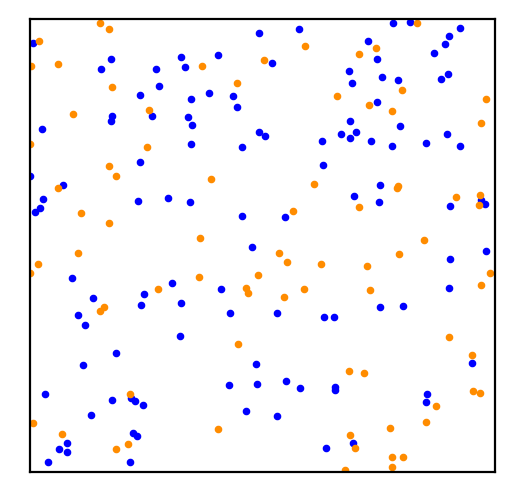

In [5]:
(cell_pos, cell_type) = get_sim_data(frame_max, foldername)

xpos = cell_pos[:,0]
ypos = cell_pos[:,1]

reds = cell_type == 1
greens = cell_type == 2

greenxpos = xpos[greens]
greenypos = ypos[greens]
redxpos = xpos[reds]
redypos = ypos[reds]

tot_cells = len(xpos)
num_cells_blue = np.sum(greens)
num_cells_orange = np.sum(reds)

print("Number of cells: " + repr(tot_cells))
print("Number of blue cells: " + repr(num_cells_blue) + " ( " + repr(num_cells_blue/tot_cells) + "% )")
print("Number of orange cells: " + repr(num_cells_orange) + " ( " + repr(num_cells_orange/tot_cells) + "% )")

visualize_sim_data([greenxpos, greenypos, redxpos, redypos])

In [6]:
theta_vals, num_reds, num_greens, num_cells = angularcount(cell_pos, cell_type)

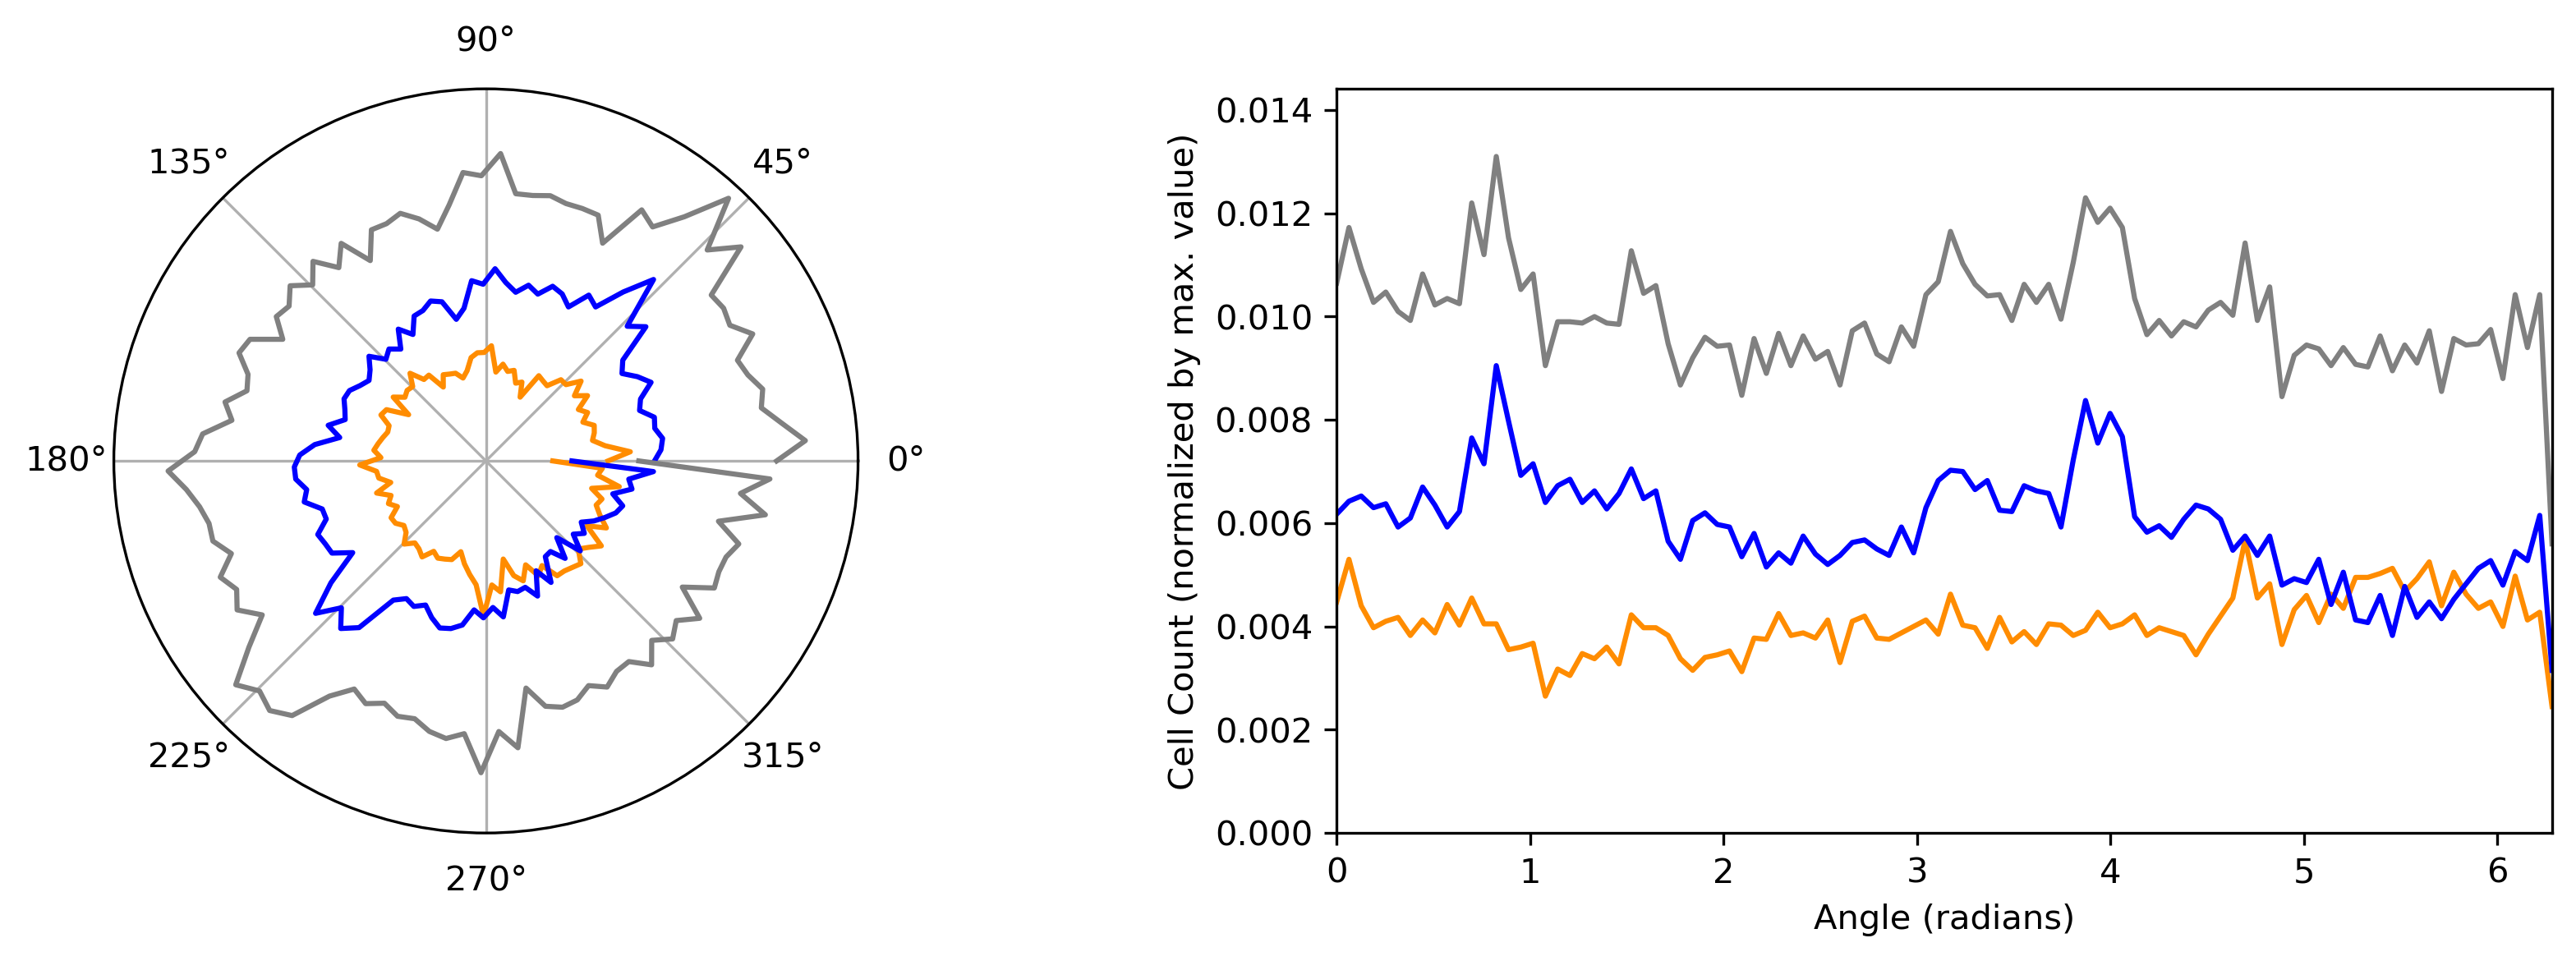

In [7]:
plotangularcount(theta_vals, num_reds, num_greens, num_cells, True, output_folder, "AngDist.png")

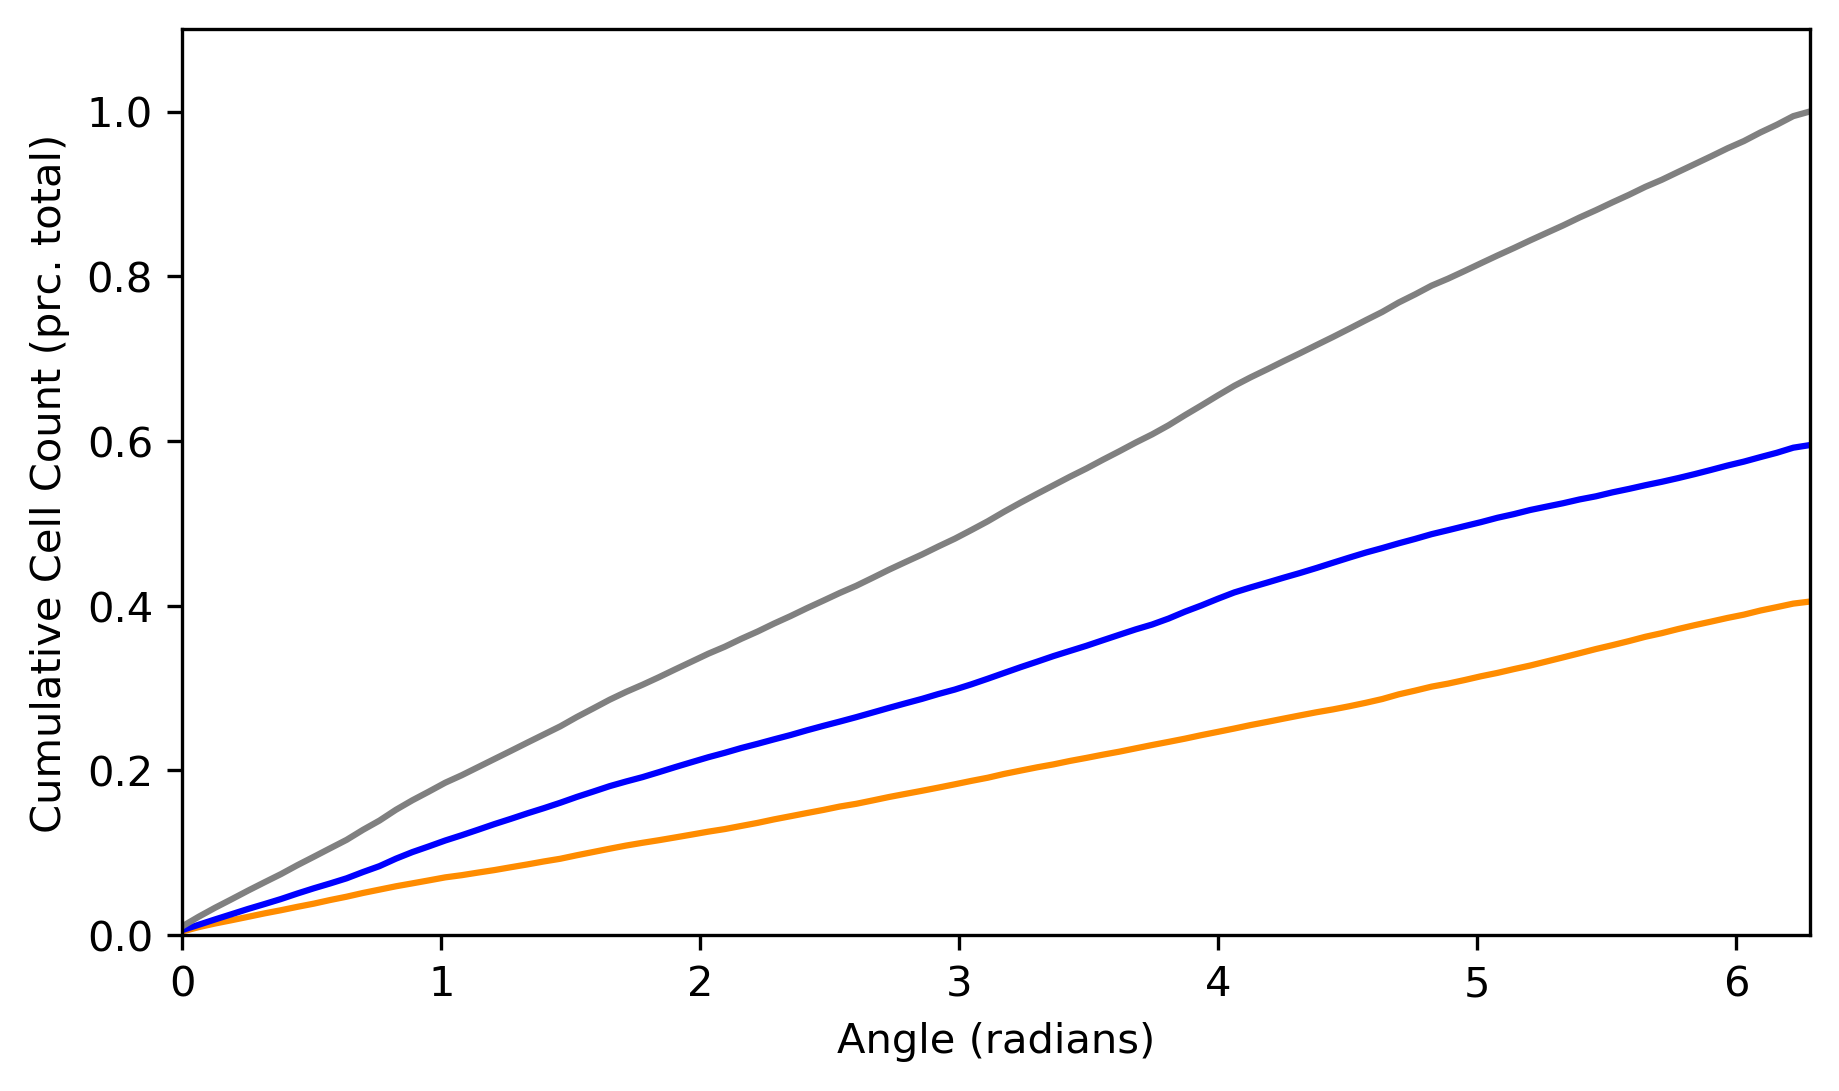

In [8]:
plotangularcumsum(theta_vals, num_reds, num_greens, num_cells, True, output_folder, "CumulativeAngDist.png")

In [9]:
save_data = dict()
save_data['theta'] = theta_vals
save_data['red'] = num_reds
save_data['green'] = num_greens
save_data['all'] = num_cells

with open(save_folder + os.sep + "AngDist.npy", 'wb') as fh:
    np.save(fh, save_data)

In [10]:
r_vals, n_reds, n_greens, n_cells, gamma_red, gamma_green, gamma_both = ensemble_avg_count(cell_pos, cell_type)

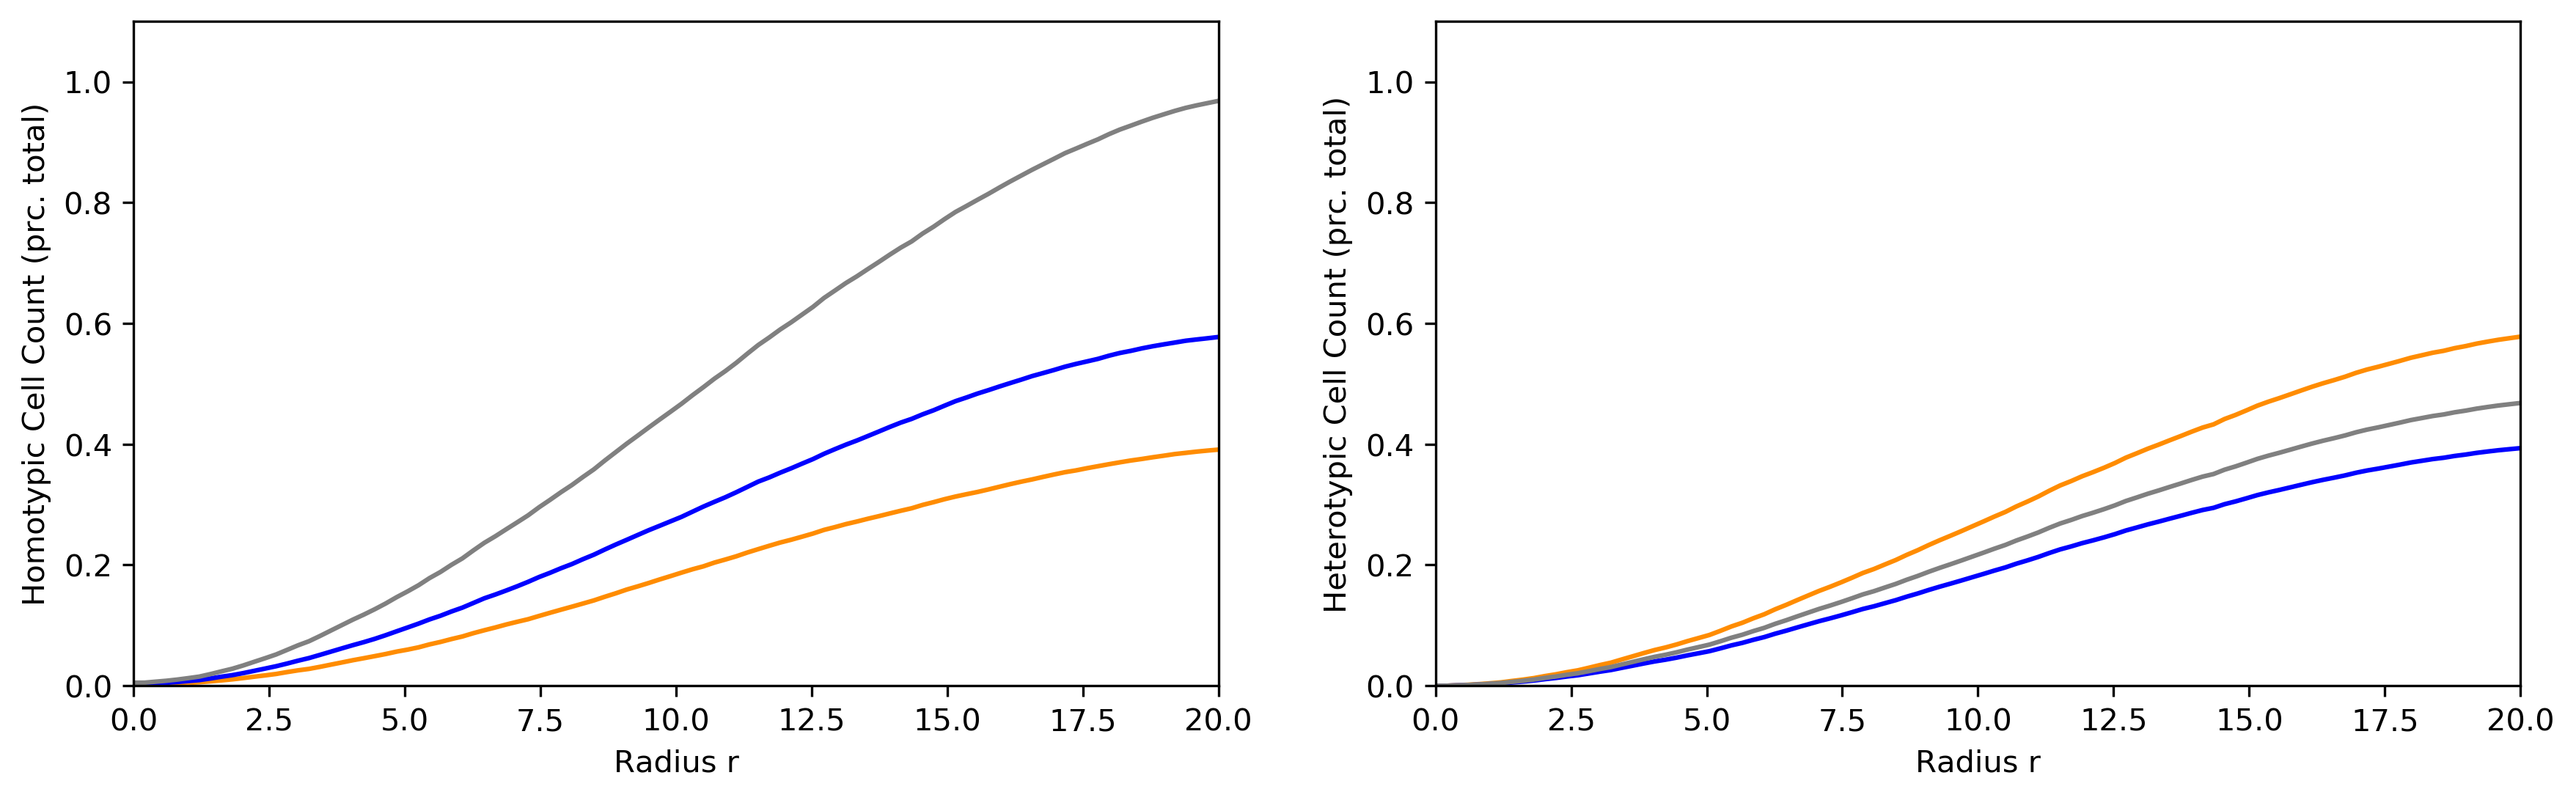

In [11]:
plotensembleavg(r_vals, n_reds, n_greens, n_cells, gamma_red, gamma_green, gamma_both, 
                True, output_folder, "RadDist.png")

In [12]:
save_data = dict()
save_data['r'] = r_vals
save_data['homotypic_red'] = n_reds
save_data['homotypic_green'] = n_greens
save_data['homotypic_all'] = n_cells
save_data['heterotypic_red'] = gamma_red
save_data['heterotypic_green'] = gamma_green
save_data['heterotypic_all'] = gamma_both

with open(save_folder + os.sep + "RadDist.npy", 'wb') as fh:
    np.save(fh, save_data)